In [1]:
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt
from gensim.matutils import any2sparse
from gensim.models import LdaModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [3]:
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [4]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train__docs, test__docs, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train__docs, val_documents, train_labels, val_labels = train_test_split(
    train__docs, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train__docs)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test__docs)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [5]:
# Print example doc
print(f'What does one instance look like from the training set? \n\n{train__docs[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

Eli Lilly & Co. (LLY) Has Broken Out To A New High On AstraZeneca Collaboration
...and here is its corresponding label 

2


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [6]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, _docs):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(_docs)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [7]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train__docs)
X_train = vectorizer.transform(train__docs)
X_val = vectorizer.transform(val_documents)
X_test__docs = vectorizer.transform(test__docs)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['$', 'aapl', 'be', 'now', 'beat', 'down', ',', 'hat', 'etc', '.']


In [8]:
# Checking full vocabulary size:
print('Full vocabulary size: {}'.format(len(vectorizer.vocabulary_)))
vocabulary = vectorizer.vocabulary_

Full vocabulary size: 10702


              precision    recall  f1-score   support

           0       0.71      0.50      0.59        50
           1       0.60      0.19      0.29        31
           2       0.66      0.91      0.77        97

    accuracy                           0.67       178
   macro avg       0.66      0.53      0.55       178
weighted avg       0.67      0.67      0.63       178



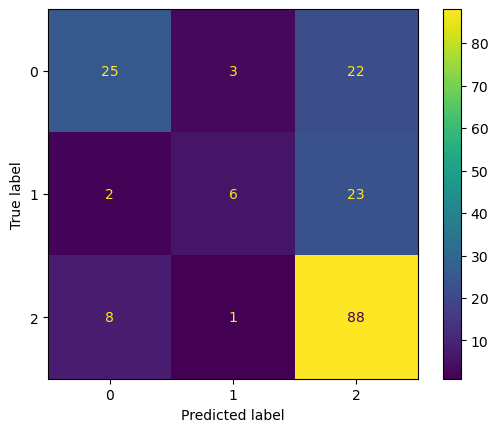

In [9]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [10]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [11]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test__docs.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test__docs.multiply(lexicon_neg_scores), axis=1)

In [12]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test__docs = hstack((X_test__docs, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.68      0.50      0.57        50
           1       0.60      0.19      0.29        31
           2       0.66      0.89      0.75        97

    accuracy                           0.66       178
   macro avg       0.64      0.53      0.54       178
weighted avg       0.65      0.66      0.62       178



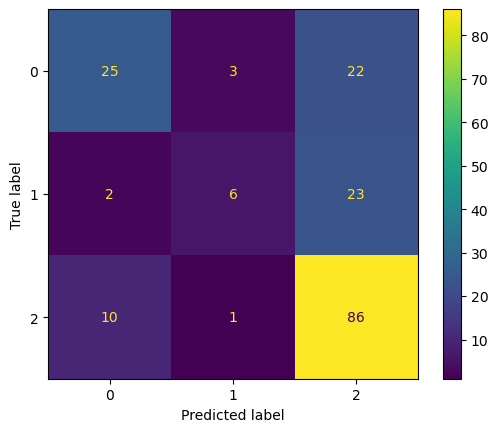

In [13]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [14]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the _docs where the classifier made an error:
_docs_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'doc: {_docs_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

doc: Looking for a strong bounce $SPY -- Lunchtime rally coming. $DIA $IWM $QQQ $AA $FB; true label = 2, prediction = 0.
doc: $FB they are hitting  everything in sight.short it. but twtr; true label = 0, prediction = 2.
doc: $CAT is hangin on my a thread. 1click away from a cliff drop.. Needs follow through (or snap-back on the VIX); true label = 0, prediction = 2.
doc: Kingfisher takeover of Mr Bricolage could hit a brick wall; true label = 0, prediction = 2.
doc: Investors Remain Skeptical About Shell-BG Deal; true label = 0, prediction = 2.
doc: UPDATE: Barclays Expects Gain After Settling With Lehman Bros Trustee; true label = 1, prediction = 2.
doc: $AAPL at pivot area on intraday chart- break here could send this to 50-day SMA, 457.80 http://stks.co/jPbN; true label = 1, prediction = 2.
doc: Breakingviews: IAG can pay more for Aer Lingus; true label = 1, prediction = 2.
doc: Morning Agenda: Shire's Deal for NPS; true label = 1, prediction = 2.
doc: Oil majors like Royal Dutch She

# Performance on test set

              precision    recall  f1-score   support

           0       0.69      0.56      0.62        62
           1       0.59      0.26      0.36        39
           2       0.69      0.88      0.77       122

    accuracy                           0.68       223
   macro avg       0.65      0.57      0.58       223
weighted avg       0.67      0.68      0.66       223



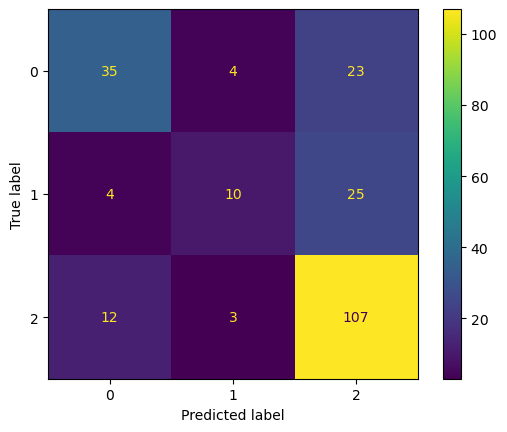

In [15]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test__docs)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [16]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train__docs, test__docs, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train__docs, val__docs, train_labels, val_labels = train_test_split(
    train__docs, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train__docs)}')
print(f'Number of validation instances = {len(val__docs)}')
print(f'Number of test instances = {len(test__docs)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [17]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train__docs:
    processed.append(preprocess(doc))
print(processed)

[['tsla', 'dip', 'test', 'day', 'ma', 'https', 'jeplmzqkgw'], ['catskillfishing', 'note', 'monthly', 'chart', 'gdx', 'recapture', 'support', 'gld', 'possible', 'double', 'set', 'http', 'stks', 'aw'], ['update', 'bhp', 'billiton', 'credit', 'rat', 'fragile', 'fy', 'agencies', 'warn'], ['profit', 'take', 'aapl', 'morning', 'pressure', 'stock', 'bullish', 'aapl'], ['astrazeneca', 'bag', 'cancer', 'drug', 'deal', 'time', 'inovio'], ['mark', 'recall', 'tesla', 'recall', 'modelx', 'faulty', 'rd', 'row', 'seat', 'https', 'hsqdovry', 'tsla', 'https', 'cs', 'cnzebb'], ['sales', 'boost', 'new', 'morrisons', 'chief', 'david', 'potts', 'tesco', 'turnaround', 'stall'], ['investors', 'remain', 'skeptical', 'shell', 'bg', 'deal'], ['kraft', 'cadbury', 'britvic', 'total', 'recall', 'pull', 'product', 'affect', 'profit'], ['short', 'faz', 'know', 'mean', 'market', 'tank'], ['crh', 'add', 'cr', 'laurence', 'acquisitions', 'tally', 'bn'], ['barclays', 'sell', 'benchmark', 'indices', 'unit', 'bloomberg'],

In [18]:
from gensim.corpora import Dictionary
# create a dictionary of word:id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2321 unique tokens: ['day', 'dip', 'https', 'jeplmzqkgw', 'ma']...)


In [19]:
# Getting means of thetas and training the LDA.



lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_doc_topic_dists(_docs, lda_model):
    thetas = []
    for i in range(len(_docs)):
        # Get the doc
        unseen_doc = _docs[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_doc))

        theta_doc = lda_model[bow_vector]

        thetas.append(theta_doc)

    return thetas

thetas = get_doc_topic_dists(val__docs, lda_model)

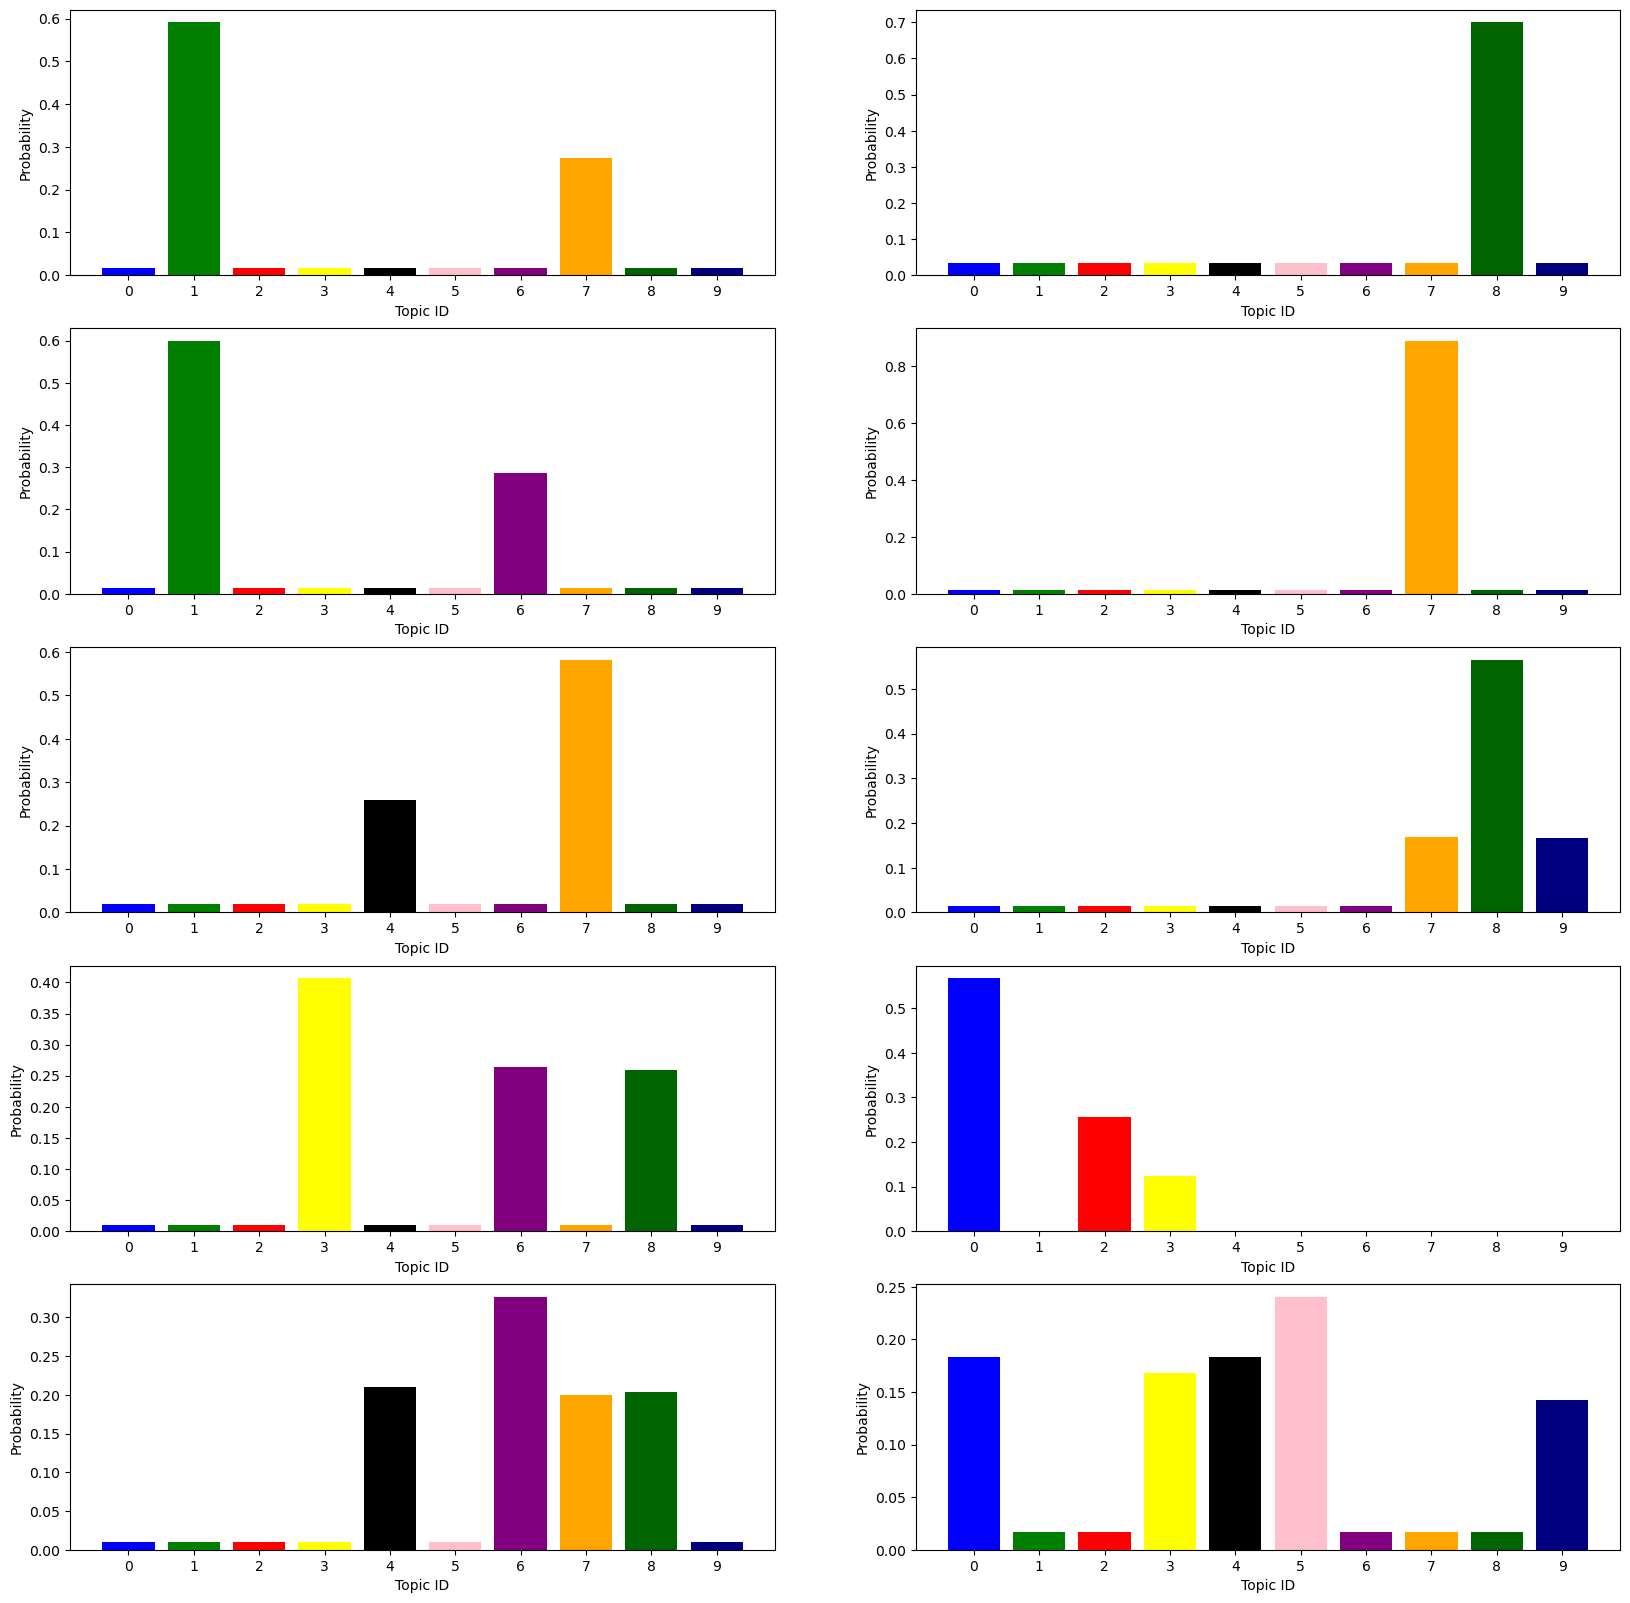

In [20]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num__docs, num_topics):
    plt.subplot(int((num__docs+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))
    plt.xlabel("Topic ID")
    plt.ylabel("Probability")
plt.figure(figsize=(20,20))

num__docs = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num__docs, num_topics)
        counter +=1
plt.show()

# Visualizing topic distributions across labels using validation set

In [21]:
# Merge arrays for later 
arr = val__docs
arr_2 = val_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['easyJet expects resilient demand to withstand security fears' '1']
 ['Key level to watch in $FB for today is 25.53-- watching to see if it can hold as support http://stks.co/bOH4'
  '1']
 ['Petrofac share price rises despite Â£30m costs on North Sea project'
  '1']
 ["$WGO's BoD was right to reject the offer. That company is low because of the economy, not because of any type of mismanagement or anything."
  '1']
 ['Tesco sells Blinkbox and broadband service to TalkTalk' '1']
 ['volatility squeeze in $AAPL. I hope it gets resolved to the upside'
  '1']
 ['UPDATE 1-SABMiller 2nd-quarter underlying sales rise, forex impacts margins'
  '1']
 ['$AAPL 620 resistance area' '1']
 ['Aviva shuts Friends Life head office in rapid integration move' '1']
 ['$RIG whos ever pushing this is crazy, get ready for suspended dividend (turning into growth stock) blow out earnings, and major buyback, lol'
  '1']
 ['RT @andrewnyquist Chartology: Yahoo: http://stks.co/1itr $YHOO  Crazy looking chart, but 

In [22]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_doc_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_doc_topic_dists
        thetas_t_sparse = get_doc_topic_dists(val__docs[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_doc_mean_topics()

print(mean_arr.shape)

[0.11828443 0.16227575 0.08530347 0.1007031  0.05749441 0.06442431
 0.06741145 0.1495437  0.14606305 0.04505106]
[0.1675447  0.08278194 0.1426444  0.09427196 0.05590709 0.111289
 0.08344137 0.16197479 0.03245559 0.06157768]
[0.09278477 0.0873886  0.114818   0.05951668 0.06823829 0.09545884
 0.09142448 0.19056383 0.13886264 0.05084727]
(3, 10)


[0.1082809  0.16227919 0.08530436 0.10843412 0.05749612 0.06776157
 0.06742205 0.14287903 0.14605706 0.05064034]
[0.16751958 0.08279706 0.1426406  0.09426671 0.05593557 0.11129385
 0.08343246 0.16199524 0.03245839 0.06154905]
[0.08998511 0.09760794 0.11497898 0.05951687 0.06626708 0.09546646
 0.08814879 0.19450856 0.1325592  0.05086441]


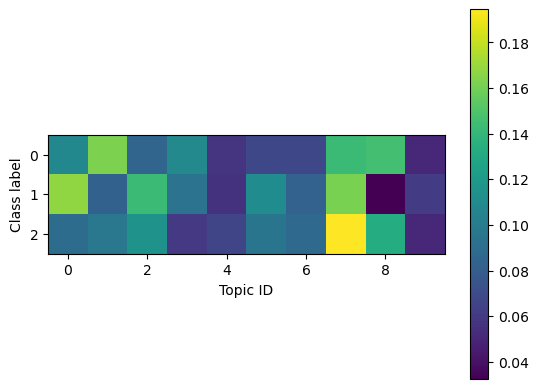

In [23]:
def plot_doc_topic_matrix():
    # Get mean doc topics dists
    mean_thetas = get_doc_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_doc_topic_matrix()

In [24]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.018*"aapl" + 0.017*"plc" + 0.012*"buy" + 0.012*"https" + 0.011*"spy" + 0.009*"sell" + 0.007*"group" + 0.006*"look" + 0.006*"tesco" + 0.005*"apple"


Topic ID: 1 
Associated Words:
 0.017*"https" + 0.015*"astrazeneca" + 0.012*"tsla" + 0.012*"drug" + 0.011*"price" + 0.011*"recall" + 0.009*"sell" + 0.009*"deal" + 0.008*"tesla" + 0.008*"profit"


Topic ID: 2 
Associated Words:
 0.015*"stks" + 0.015*"http" + 0.013*"sales" + 0.011*"https" + 0.008*"high" + 0.007*"new" + 0.007*"spy" + 0.007*"boost" + 0.007*"bid" + 0.007*"short"


Topic ID: 3 
Associated Words:
 0.028*"share" + 0.026*"price" + 0.020*"inbev" + 0.017*"sabmiller" + 0.016*"ab" + 0.012*"close" + 0.009*"deal" + 0.007*"expect" + 0.006*"year" + 0.006*"plan"


Topic ID: 4 
Associated Words:
 0.009*"tsla" + 0.007*"market" + 0.007*"report" + 0.007*"way" + 0.007*"fall" + 0.007*"dividend" + 0.006*"short" + 0.005*"stks" + 0.005*"http" + 0.005*"recall"


Topic ID: 5 
Associated Words:
 0.015*"buy" + 0.008*"de

# Using test set

In [25]:
# Merge arrays for later 
arr = test__docs
arr_2 = test_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_doc_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_doc_topic_dists
        thetas_t_sparse = get_doc_topic_dists(test__docs[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense_vector(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_doc_mean_topics()

def plot_doc_topic_matrix():
    # Get mean doc topics dists
    mean_thetas = get_doc_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.xlabel("Topic ID")
    plt.ylabel("Class label")
    plt.show()
plot_doc_topic_matrix()

[['PRESS: Serco Set To Appoint Roy Gardner, Ex-Centrica, As Chairman - FT'
  '1']
 ["stole my tweet. really wouldn't be surprised if we took out 423 and pinned around it RT @totalguru We could possibly even see425 today $AAPL"
  '1']
 ['Should You Follow Berkshire Hathaway Into Apple Stock?' '1']
 ["Barclays appoints JPMorgan's Paul Compton as new COO" '1']
 ['Sold some $TSLA Puts this morning Closed them at the close. Helps pay for monthly expenses'
  '1']
 ['$AAPL a new long IF 110.61 is broken. Targets are 112.19, 119.86 & 123.82. Bears must retake 102.77. $QQQ $NQ_F $NDX https://t.co/6l3m1wXChw'
  '1']
 ['Phew! So far good $BBRY did not break 10.40 coz I was told that is key support level.'
  '1']
 ["Tesco closes in on new chairman with Dixons Carphone's John Allan in the frame"
  '1']
 ['$ACAD under $2 today?' '1']
 ['Tesco Abandons Video-Streaming Ambitions in Blinkbox Sale' '1']
 ['Tesco share price steady as analysts weigh in on results' '1']
 ['Philip Morris, BAT Sue Over Law 